<h2>IMS Bearing Data RUL 예측</h2>


사용 데이터 :  <a href="https://www.kaggle.com/datasets/vinayak123tyagi/bearing-dataset">[IMS Bearing Dataset]</a></b></h3>

원본 코드 (Original Code) :  https://www.kaggle.com/code/furkancitil/nasa-bearing-dataset-rul-prediction  
 
<h3>RUL 예측 과정</h3>

- Step 1 : Kurtosis, RMS 등의 신호처리 기법을 활용하여 데이터 신호처리

- Step 2 : Exponential Moving Average Filter를 사용하여 데이터의 노이즈 제거

- Step 3 : PCA 기법을 활용하여 기존 다양한 신호처리 된 변수들을 차원축소, PC1을 Degradation Factor로 사용

- Step 4 : Step 3에서 추출한 Degradation Factor에 Exponential Model과 사전 정의된 Failure Threshold를 적용하여 RUL 예측

In [22]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
from scipy.stats import entropy
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

In [23]:
#Data paths
dataset_path_1st = 'E:\\연구실\\데이터\\예지보전\\IMS bearing data\\originalData\\archive\\1st_test'
dataset_path_2nd = 'E:\\연구실\\데이터\\예지보전\\IMS bearing data\\originalData\\archive\\2nd_test'
dataset_path_3rd = 'E:\\연구실\\데이터\\예지보전\\IMS bearing data\\originalData\\archive\\3rd_test'

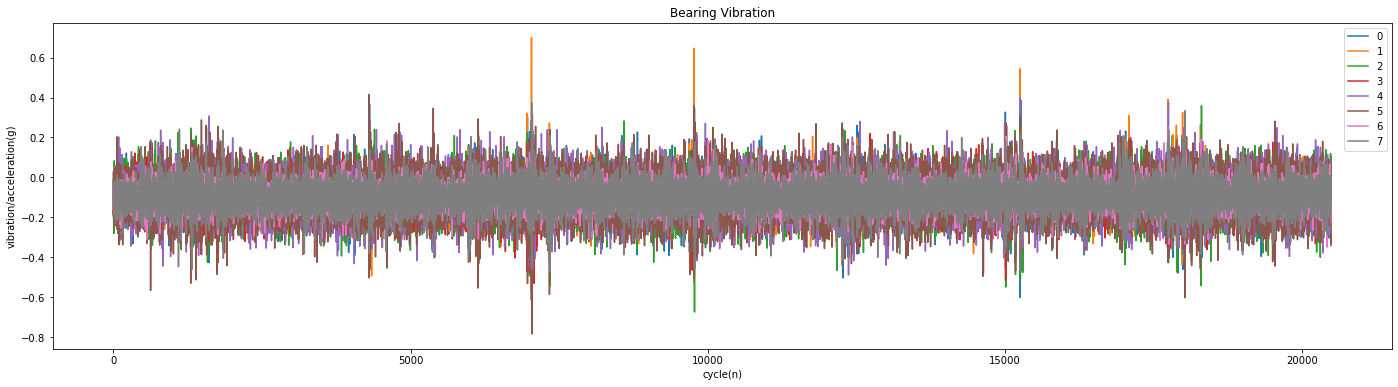

In [24]:
# Test for the first file
dataset = pd.read_csv('E:/연구실/데이터/예지보전/IMS bearing data/originalData/archive/1st_test/2003.10.22.12.06.24', sep='\t', header=None)
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

In [25]:
# Root Mean Squared Sum
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

# extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

# extract shannon entropy (cut signals to 500 bins)
def calculate_entropy(df):
    ent = []
    for col in df:
        ent.append(entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(ent)
# extract clearence factor
def calculate_clearence(df):
    result = []
    for col in df:
        r = ((np.sqrt(df[col].abs())).sum() / len(df[col]))**2
        result.append(r)
    return result

def time_features(dataset_path, id_set=None):
    time_features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p', 'crest', 'clearence', 'shape', 'impulse']
    cols1 = ['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
    cols2 = ['B1','B2','B3','B4']
    
    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in time_features]
        data = pd.DataFrame(columns=columns)

        
        
    for filename in os.listdir(dataset_path):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        
        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
        crest = max_abs/rms
        clearence = np.array(calculate_clearence(raw_data))
        shape = rms / mean_abs
        impulse = max_abs / mean_abs
        
        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
            crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
            clearence = pd.DataFrame(clearence.reshape(1,8), columns=[c+'_clearence' for c in cols1])
            shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
            impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_impulse' for c in cols1])
            
        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
            crest = pd.DataFrame(crest.reshape(1,4), columns=[c+'_crest' for c in cols2])
            clearence = pd.DataFrame(clearence.reshape(1,4), columns=[c+'_clearence' for c in cols2])
            shape = pd.DataFrame(shape.reshape(1,4), columns=[c+'_shape' for c in cols2])
            impulse = pd.DataFrame(impulse.reshape(1,4), columns=[c+'_impulse' for c in cols2])
            
        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
        crest.index = [filename]
        clearence.index = [filename]
        shape.index = [filename]
        impulse.index = [filename] 
        
        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearence, shape, impulse], axis=1)
        data = data.append(merge)
        
    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data                   

In [26]:
# set1 = time_features(dataset_path_1st, id_set=1)
# set1.to_csv('E:\\연구실\\데이터\\예지보전\\IMS bearing data\\set1_timefeatures.csv', index=False)

In [232]:
set1 = pd.read_csv('E:\\연구실\\데이터\\예지보전\\IMS bearing data\\set1_timefeatures.csv')
set1 = set1.rename(columns={'Unnamed: 0':'time'})
last_cycle = int(len(set1))

In [219]:
set1

,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,B1_x_clearence,...,B4_y_skew,B4_y_kurtosis,B4_y_entropy,B4_y_rms,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearence,B4_y_shape,B4_y_impulse
0,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,0.090932,...,0.008208,1.808719,4.690580,0.115266,0.471,0.845,4.086202,0.089551,1.158299,4.733045
1,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,0.090784,...,-0.053721,1.873845,4.666142,0.109210,0.627,0.900,5.741234,0.083762,1.166936,6.699653
2,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,0.092058,...,0.047069,1.430242,4.681037,0.113695,0.601,0.977,5.286066,0.088436,1.156631,6.114027
3,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,0.091833,...,0.021169,1.378689,4.696194,0.114415,0.525,0.852,4.588565,0.088515,1.160373,5.324447
4,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,0.091479,...,0.008713,1.498303,4.693572,0.114260,0.522,0.871,4.568532,0.088455,1.160343,5.301063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,0.138784,0.120934,0.000689,0.477060,5.204127,0.168642,0.669,1.145,3.966977,0.120038,...,-0.018975,0.671997,5.335049,0.193002,0.786,1.394,4.072505,0.131724,1.247509,5.080488
2152,0.142147,0.129748,-0.052217,0.555174,5.191541,0.174977,0.803,1.316,4.589186,0.121725,...,-0.021172,0.514551,5.305560,0.204552,0.908,1.616,4.438966,0.138314,1.253199,5.562906
2153,0.142098,0.128376,-0.080830,0.383461,5.283214,0.174572,0.710,1.159,4.067083,0.121949,...,-0.076739,0.537004,5.307928,0.208231,0.911,1.648,4.374943,0.140434,1.256528,5.497239
2154,0.141889,0.126898,-0.009047,0.515840,5.249904,0.173459,0.776,1.298,4.473683,0.122149,...,-0.037235,0.563250,5.185493,0.202329,1.157,1.780,5.718411,0.136872,1.252521,7.162427


<h1> Signal Processing </h1>

In [52]:
set1_mean = set1.iloc[:,np.arange(0,96,12)]
set1_std = set1.iloc[:,np.arange(1,96,12)]
set1_skew = set1.iloc[:,np.arange(2,96,12)]
set1_kurtosis = set1.iloc[:,np.arange(3,96,12)]
set1_entropy = set1.iloc[:,np.arange(4,96,12)]
set1_rms = set1.iloc[:,np.arange(5,96,12)]
set1_max_abs = set1.iloc[:,np.arange(6,96,12)]
set1_p2p = set1.iloc[:,np.arange(7,96,12)]
set1_crest = set1.iloc[:,np.arange(8,96,12)]
set1_clearence = set1.iloc[:,np.arange(9,96,12)]
set1_shape = set1.iloc[:,np.arange(10,96,12)]
set1_impulse = set1.iloc[:,np.arange(11,96,12)]

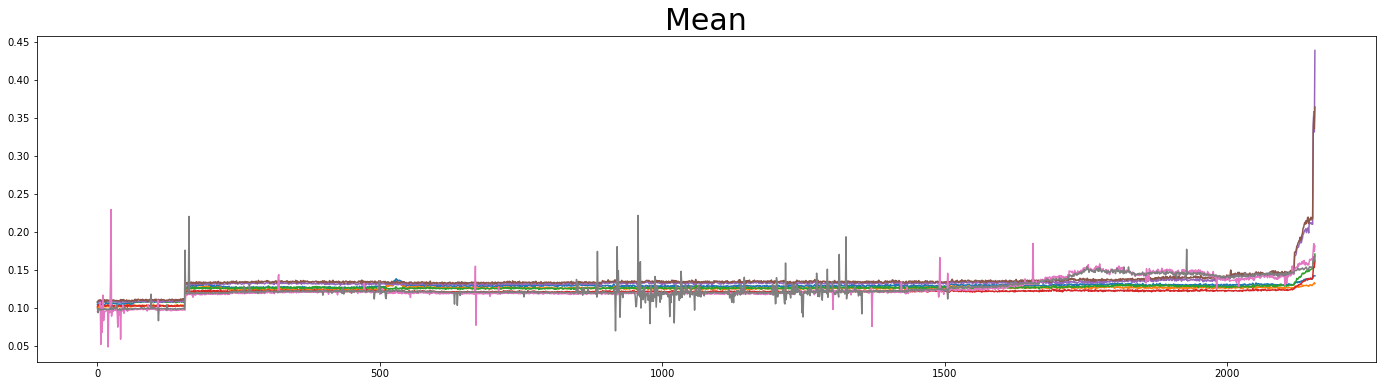

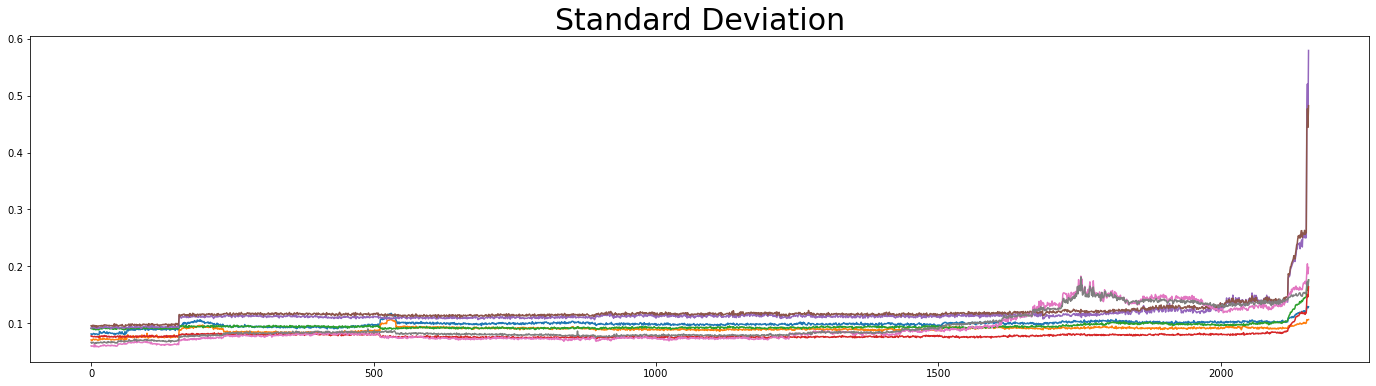

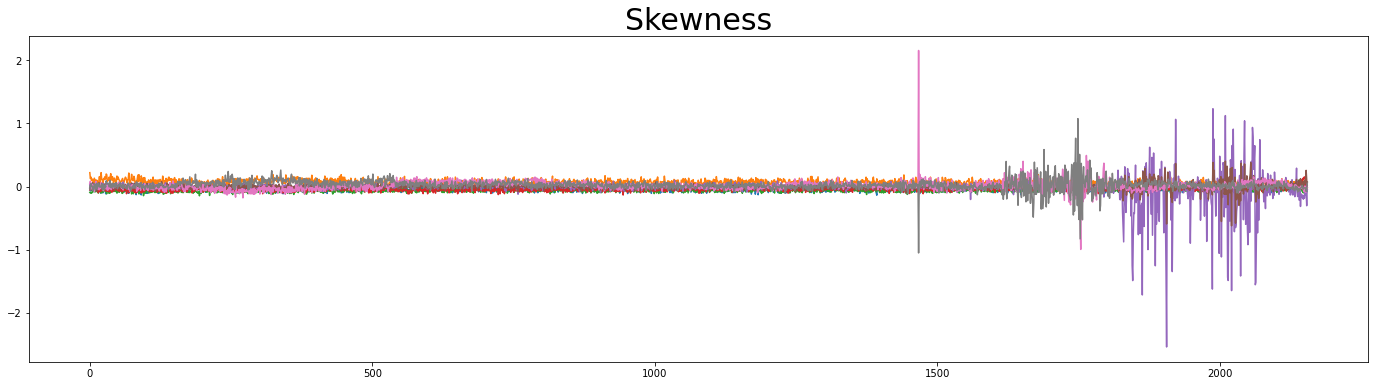

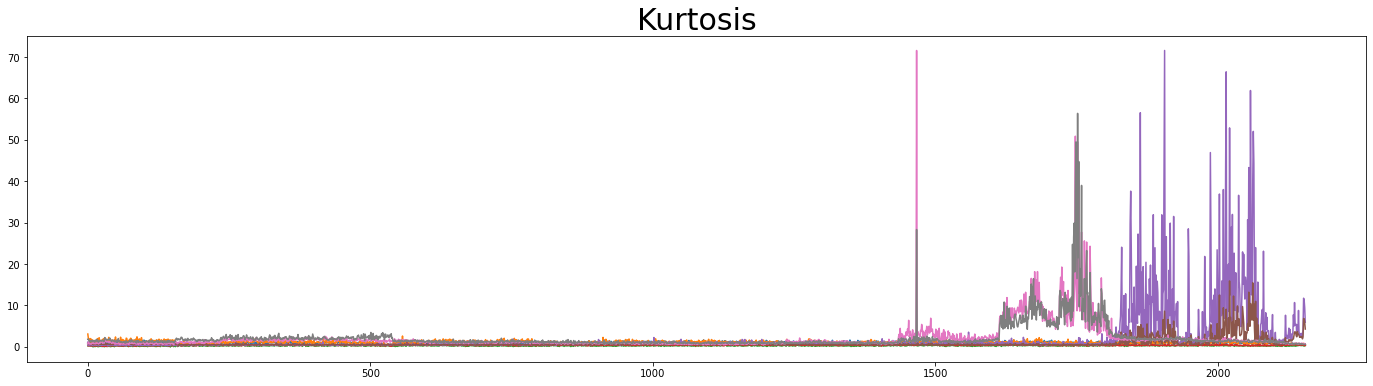

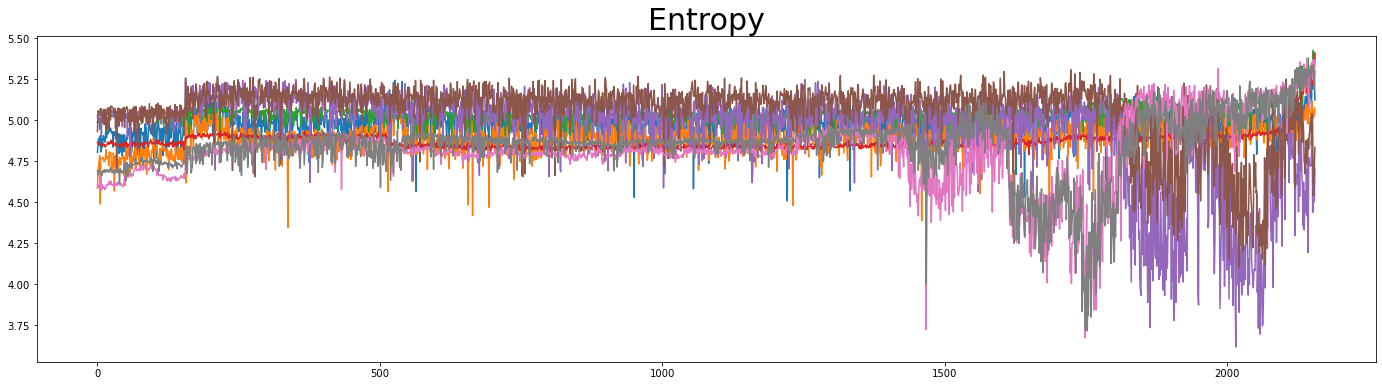

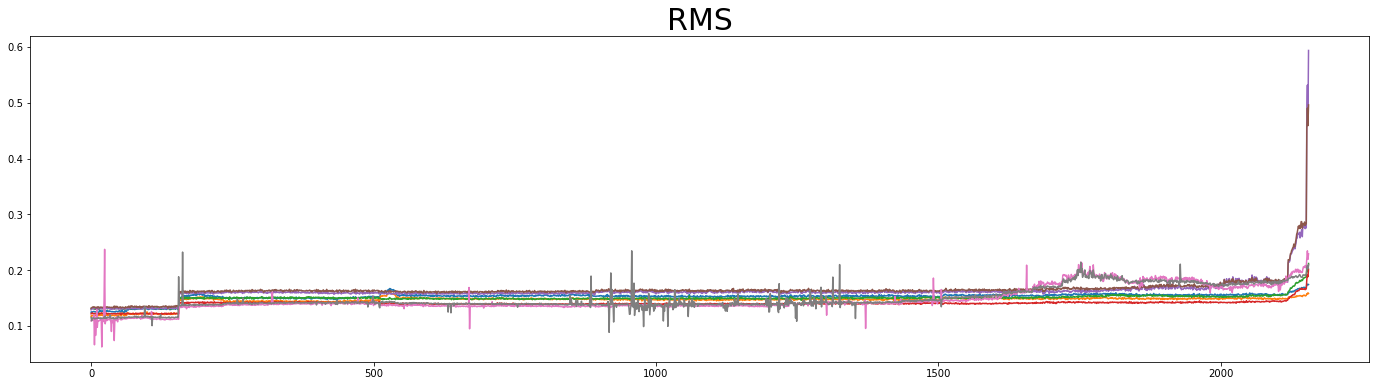

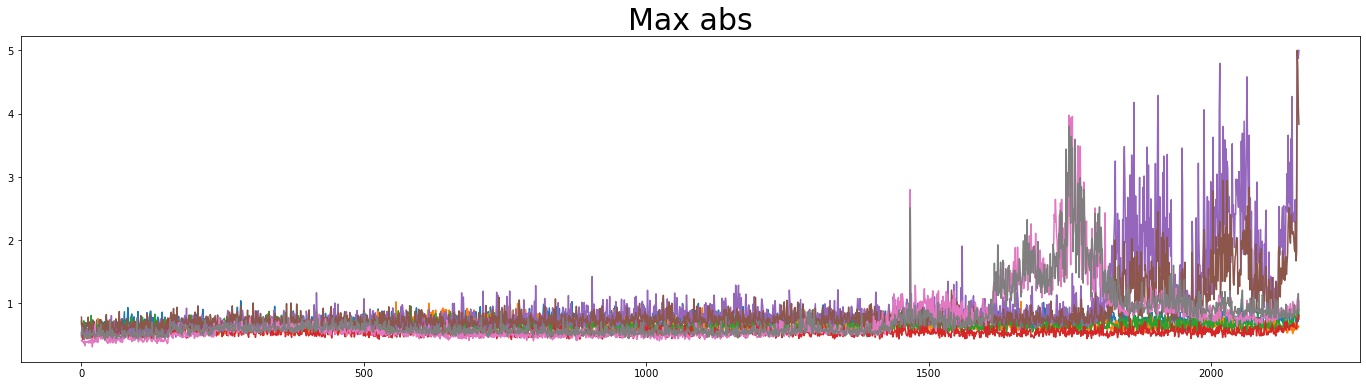

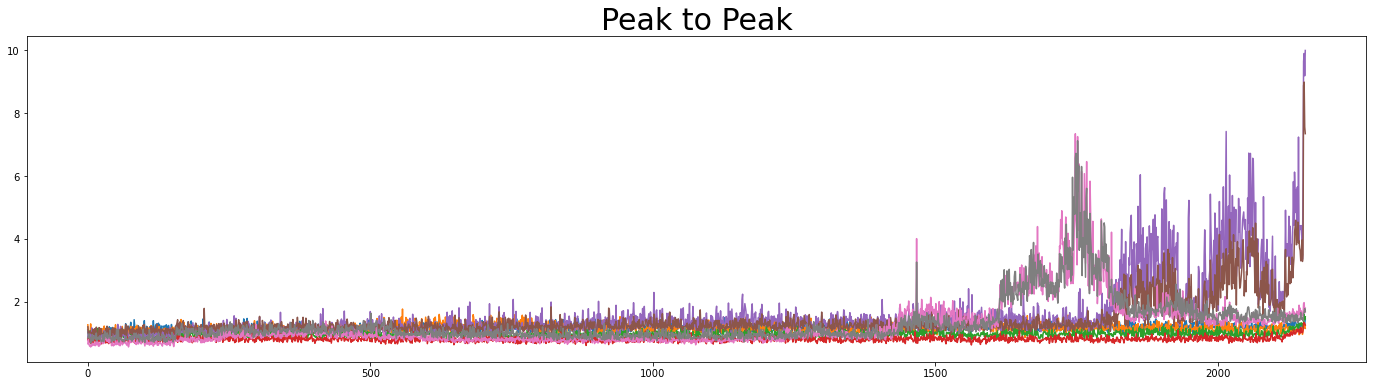

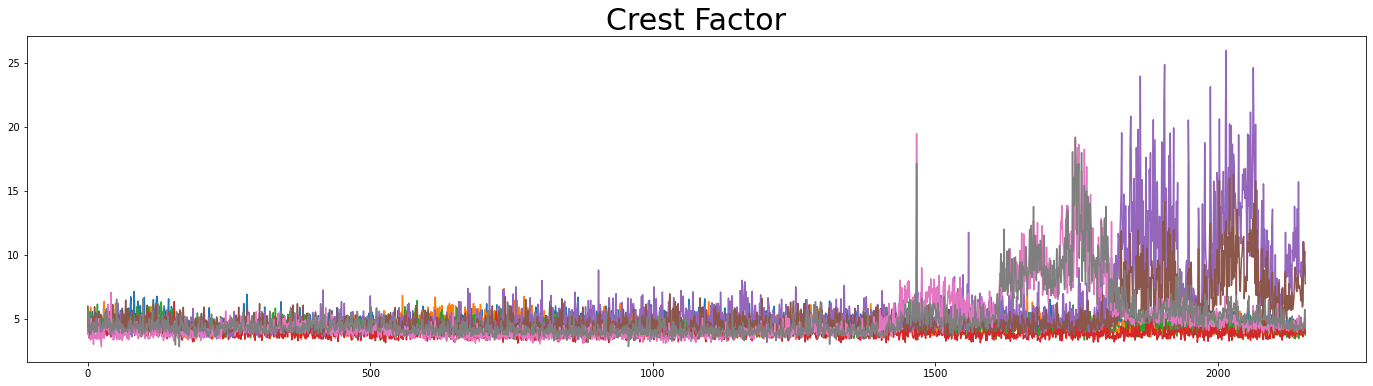

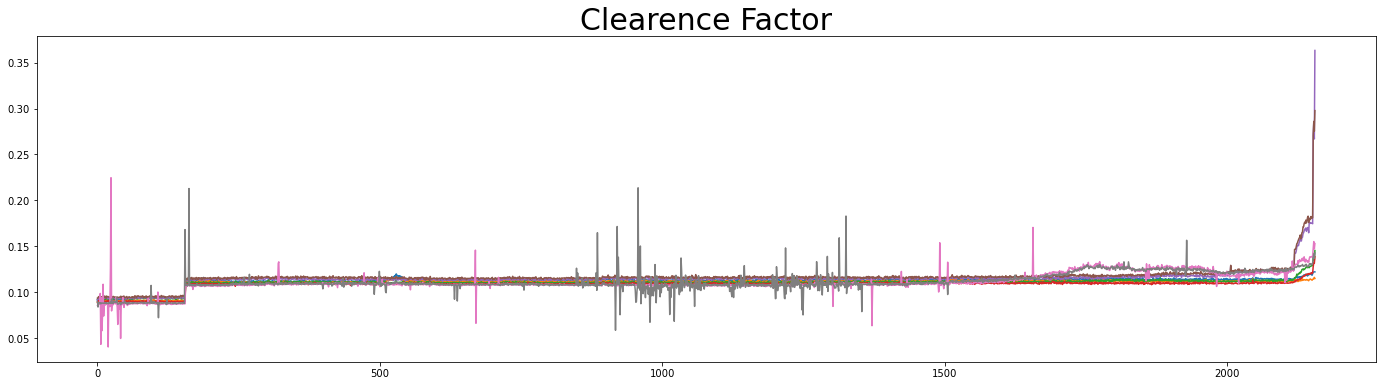

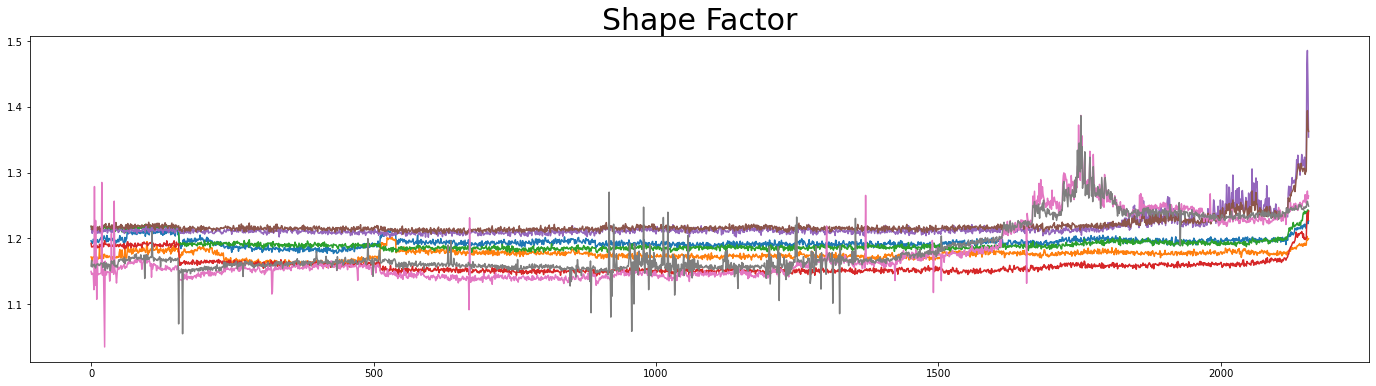

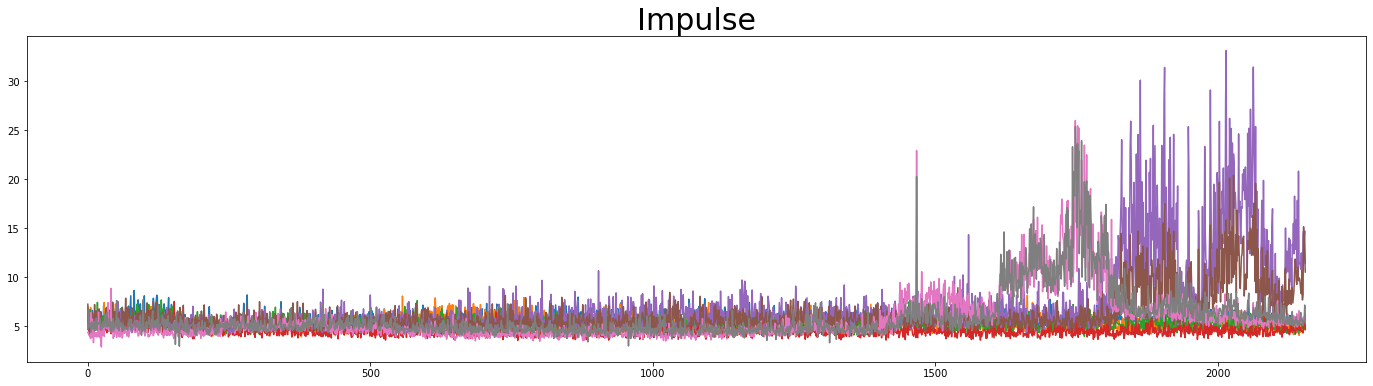

In [64]:
# Mean
plt.figure(figsize = (24,6))
plt.plot(set1_mean)
plt.title('Mean', fontsize=30)
plt.show()

# Standard Deviation
plt.figure(figsize = (24,6))
plt.plot(set1_std)
plt.title('Standard Deviation', fontsize=30)
plt.show()

# Skewness (왜도)
plt.figure(figsize = (24,6))
plt.plot(set1_skew)
plt.title('Skewness', fontsize=30)
plt.show()

# Kurtosis
plt.figure(figsize = (24,6))
plt.plot(set1_kurtosis)
plt.title('Kurtosis', fontsize=30)
plt.show()

# Entropy
plt.figure(figsize = (24,6))
plt.plot(set1_entropy)
plt.title('Entropy', fontsize=30)
plt.show()

# RMS
plt.figure(figsize = (24,6))
plt.plot(set1_rms)
plt.title('RMS', fontsize=30)
plt.show()

# Max abs
plt.figure(figsize = (24,6))
plt.plot(set1_max_abs)
plt.title('Max abs', fontsize=30)
plt.show()

# Peak to Peak
plt.figure(figsize = (24,6))
plt.plot(set1_p2p)
plt.title('Peak to Peak', fontsize=30)
plt.show()

# Crest Factor
plt.figure(figsize = (24,6))
plt.plot(set1_crest)
plt.title('Crest Factor', fontsize=30)
plt.show()

# Clearence Factor
plt.figure(figsize = (24,6))
plt.plot(set1_clearence )
plt.title('Clearence Factor', fontsize=30)
plt.show()

# Shape Factor
plt.figure(figsize = (24,6))
plt.plot(set1_shape)
plt.title('Shape Factor', fontsize=30)
plt.show()

# Impulse
plt.figure(figsize = (24,6))
plt.plot(set1_impulse)
plt.title('Impulse', fontsize=30)
plt.show()

<h1> Moving Average Filter </h1>

In [75]:
features = set1.copy()

# simple moving average SMA
ma = pd.DataFrame()
ma['B4_x_mean'] = features['B4_x_mean']
ma['SMA'] = ma['B4_x_mean'].rolling(window=5).mean()

In [82]:
ma.head(6)

,B4_x_mean,SMA
0,0.094803,NaN
1,0.095070,NaN
2,0.096158,NaN
3,0.096814,NaN
4,0.096358,0.095840
5,0.106972,0.098274


In [97]:
#Cumulative Moving Average
ma['CMA'] = ma["B4_x_mean"].expanding(min_periods=5).mean()

In [132]:
#Exponantial Moving Average
# https://towardsdatascience.com/moving-averages-in-python-16170e20f6c 참조
ma['EMA'] = ma['B4_x_mean'].ewm(alpha=0.3,adjust=False).mean()

In [135]:
ma.head(6)

,B4_x_mean,SMA,CMA,EMA
0,0.094803,NaN,NaN,0.094803
1,0.095070,NaN,NaN,0.094883
2,0.096158,NaN,NaN,0.095265
3,0.096814,NaN,NaN,0.095730
4,0.096358,0.095840,0.095840,0.095918
5,0.106972,0.098274,0.097696,0.099234


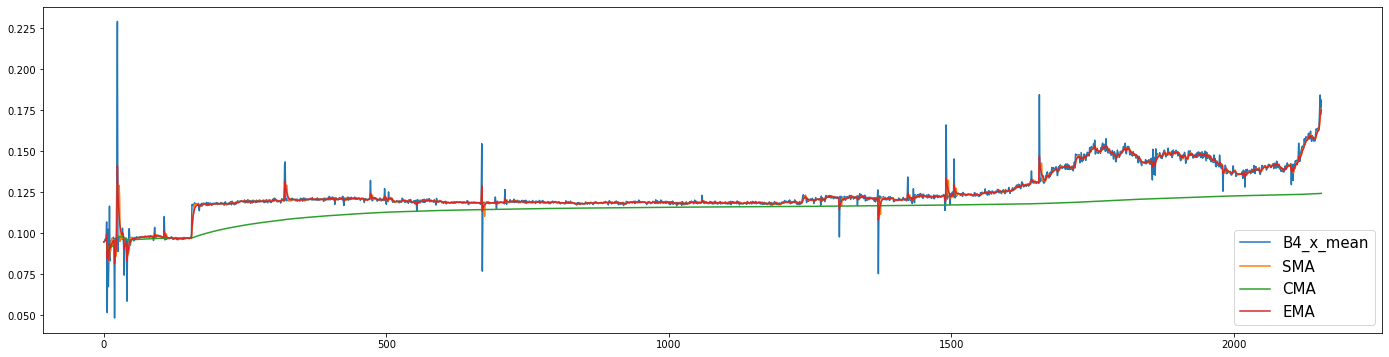

In [146]:
plt.figure(figsize = (24,6))
plt.plot(ma)
plt.legend(['B4_x_mean','SMA','CMA','EMA'], fontsize=15)
plt.show()

<h1> RUL Prediction </h1>

In [147]:
def health_indicator(bearing_data,use_filter=False):    
    data = bearing_data.copy()
    if use_filter:
        for ft in data.columns:
            data[ft] = data[ft].ewm(span=40,adjust=False).mean()
    pca = PCA()
    X_pca = pca.fit_transform(data)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    print("Explained variance of Pricincipal Component 1 is:"+str(pca.explained_variance_ratio_[0]))
    health_indicator = np.array(X_pca['PC1'])
    degredation = pd.DataFrame(health_indicator,columns=['PC1'])
    degredation['cycle'] = degredation.index
    degredation['PC1'] = degredation['PC1']-degredation['PC1'].min(axis=0)
    
    return degredation

def fit_exp(df,base=500,print_parameters=False):
    x =np.array(df.cycle)
    x = x[-base:].copy()
    y = np.array(degredation.PC1)
    y = y[-base:].copy()
    def exp_fit(x,a,b):
        y = a*np.exp(abs(b)*x)
        return y
    #initial parameters affect the result
    fit = curve_fit(exp_fit,x,y,p0=[0.01,0.001],maxfev=10000)
    if print_parameters:
        print(fit)
    return fit

def predict(X_df,p):
    x =np.array(X_df.cycle)
    a,b = p[0]
    fit_eq = a*np.exp(abs(b)*x)
    return fit_eq
log = [[],[]]

In [148]:
#variable for incrementing index
prediction_cycle = 600
#variable for keeping intial value
init_cycle = prediction_cycle

In [172]:
#selected_features = ['mean','std','kurtosis','skew','entropy',
#        'rms','max','p2p','crest','shape','impulse']
selected_features = ['max','p2p','rms']

bearing = 3
B_x = ["B{}_x_".format(bearing)+i for i in selected_features]
early_cycles = set1[B_x][:init_cycle] # 0:600
early_cycles_pca = health_indicator(early_cycles,use_filter=True)

Explained variance of Pricincipal Component 1 is:0.9955862512721826


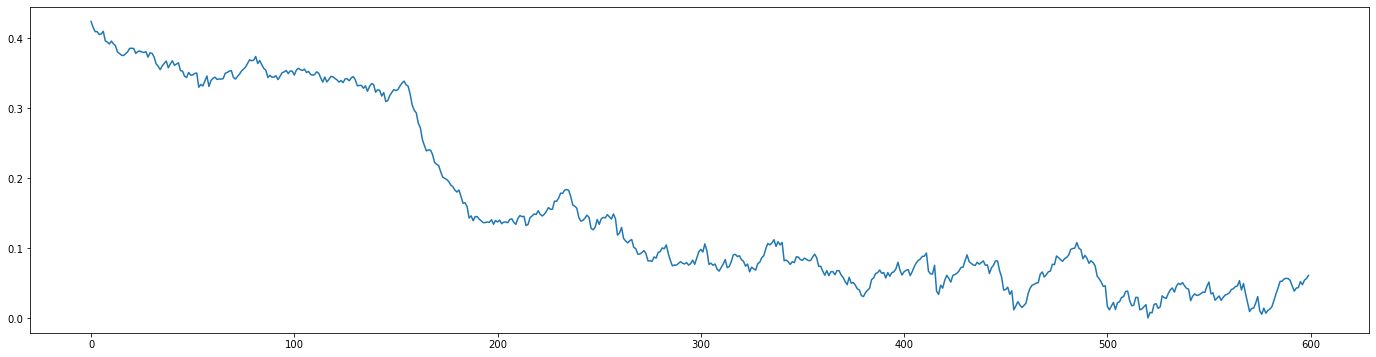

In [173]:
plt.figure(figsize = (24,6))
plt.plot(early_cycles_pca['PC1'])
plt.show()

In [277]:
#run this again, again to simulate life-cycle of a bearing
prediction_cycle = 1900

data = set1[B_x][:prediction_cycle]
ind=data.index
degredation = health_indicator(data,use_filter=True)
#degredation.plot(y='PC1',x='cycle')
fit = fit_exp(degredation,base=300)

prediction = predict(degredation,fit)
m,n = fit[0]
thres = 2 # predefined threhsold

fail_cycle = (np.log(thres/m))/abs(n)
log[0].append(prediction_cycle)
log[1].append(fail_cycle)

print(m,n)
print('failed at '+ str(fail_cycle))

Explained variance of Pricincipal Component 1 is:0.9984235244672488
4.556347174924605e-08 0.009477904723854534
failed at 1856.6663405937377


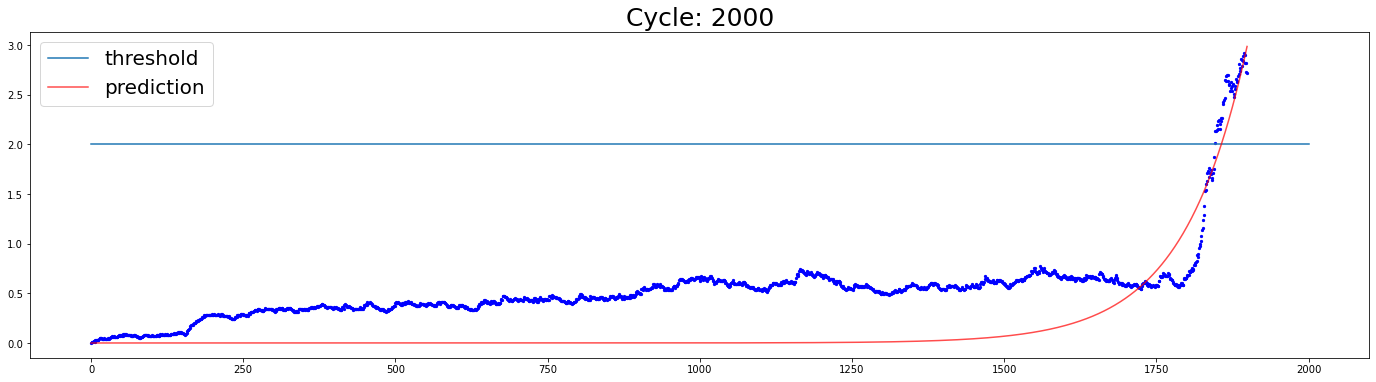

In [291]:
plt.figure(figsize = (24,6))
plt.plot([0,prediction_cycle],[2,2]) # Failure Threshold
plt.scatter(degredation['cycle'],degredation['PC1'],color='b',s=5)
plt.plot(degredation['cycle'],prediction,color='r',alpha=0.7)
plt.title('Cycle: '+str(prediction_cycle), fontsize=25)
plt.legend(['threshold','prediction'], fontsize=20)
plt.show()
increment_cycle =25
prediction_cycle += increment_cycle